# Us Patent Phrase Matching

## Introduction


- iter-like-gm-jh - https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster
- iter-like-gm-blurrified - https://www.kaggle.com/code/ohmeow/iterate-like-a-grandmaster-blurrified/notebook

Key Ideas
- choose an effective validation set 
- iterate on changes rapidly that improves on the validation set

Questions
- From Kerem Turgutlu comment https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/comments#1756927 "Special Tokens section is that **lowercasing actually breaks the tokenization** and results in not using the added special tokens (if needed everything except for special tokens can be lowercased)".
- zero initialization of the special tokens added vs default init.

Outline

- Imports & EDA
- Training Setup
- Creating a validation set
- Initial Model
- Improving the model
- Special Tokens
- Cross-validation

Things to try (suggested by Jeremy)

* Try a model pretrained on legal vocabulary. E.g. how about [BERT for patents](https://huggingface.co/anferico/bert-for-patents)?
* You'd likely get better results by using a sentence similarity model. Did you know that there's [a patent similarity model](https://huggingface.co/AI-Growth-Lab/PatentSBERTa) you could try?
* You could also fine-tune any HuggingFace model using the full patent database (which is provided in BigQuery), before applying it to this dataset
* Replace the patent context field with the description of that context provided by the patent office
* ...and try out your own ideas too!

Things to try (suggested by Wayde)

* Experiment with other smaller models that typically work well for clssification 
tasks (e.g., roberta, deberta, and bart are my go tos)
* Experiment with some bigger versions of those smaller models that worked well for you.
* Be creative with your inputs; you can improve your results by adding special or regular tokens and/or structuring your inputs differently
* Try using K-Fold or Stratified K-Fold cross validation and ensemble your results (see Jeremy's notebook for more info)
* Once you have a decent set of hyperparameters working for you, you can use an optimization framework like Optuna and/or Weights & Biases to fine-tune your choices.
* Read the papers related to the architectures you are using. Often you'll find recommended hyperparameter values and other important recommendations to training them well.


**Before submitting a model, retrain it on the full dataset, rather than just the 75% training subset we've used here.**

Tips
- TIP: For classification tasks, my go-to baseline architectures are roberta, deberta, and bart.

- TIP: To iterate quickly, choose a small or distilled model.
TIP: A good validation set is critical to every ML solution. For more info, see [How to create good validation and test sets](https://ohmeow.com/posts/2020/11/06/ajtfb-chapter-1.html#How-to-create-good-validation-and-test-sets) in my blog post on lessons learned from chapter 1 of the fastbook, "Deep Learning for Coders with fastai & PyTorch".

TIP: Transformer models are very sensitive to how to prepare your inputs, and exploring different approaches are usually worthwhile.

TIP: We'll use blurr's set_seed() method to ensure reproducibility (which is important as you iterate over different hyperparameters, explore different augmentation strategies, etc...). For a great discussion on how to do this in fastai, see the "[Solved] Reproducibility: Where is the randomness coming in?" post on the forums.

Tip: Always take a look at your batches to make sure they look right and that you understand what they represent

**Related**
- Chaii Question and Answering - https://www.kaggle.com/competitions/chaii-hindi-and-tamil-question-answering/discussion/287923. Data recipes mentioned along with augmentation techniques such as Random Cropping, Progressive Resizing, Cutout is very novel. 


## Setup and Download dataset using Kaggle API. 

In [1]:
import fastai
if fastai.__version__ < '2.6.3': 
  %pip install fastai -Uqq
  %pip install transformers -q
  %pip install datasets -q
  %pip install sentencepiece -q

     |████████████████████████████████| 197 kB 4.2 MB/s 
     |████████████████████████████████| 60 kB 9.4 MB/s 
     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 77 kB 8.4 MB/s 
     |████████████████████████████████| 596 kB 94.7 MB/s 
     |████████████████████████████████| 880 kB 67.9 MB/s 
     |████████████████████████████████| 6.6 MB 80.9 MB/s 
     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 75.8 MB/s 
     |████████████████████████████████| 212 kB 32.6 MB/s 
     |████████████████████████████████| 136 kB 75.2 MB/s 
     |████████████████████████████████| 127 kB 73.4 MB/s 
     |████████████████████████████████| 271 kB 9.1 MB/s 
     |████████████████████████████████| 144 kB 60.3 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [2]:
from fastai.imports import *

# Run the cell and select kaggle.json file downloaded fromthe Kaggle account settings page
if not Path('kaggle.json').exists():
  from google.colab import files
  files.upload()

  assert Path('kaggle.json').exists() # ensure kaggle.json file is present

  %pip install kaggle -q # install kaggle api
  %mkdir -p ~/.kaggle
  %cp kaggle.json ~/.kaggle

  #!chmod 600 ~/.kaggle/kaggle.json
  os.chmod('/root/.kaggle/kaggle.json', 600)

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c us-patent-phrase-to-phrase-matching

  0% 0.00/682k [00:00<?, ?B/s]
100% 682k/682k [00:00<00:00, 95.3MB/s]


In [4]:
import os, zipfile
ref = zipfile.ZipFile('/content/us-patent-phrase-to-phrase-matching.zip', 'r')
ref.extractall()
ref.close()

In [5]:
# from fastai.test_utils import show_install
# show_install()

## Imports and EDA

In [6]:
from fastai.imports import *

In [7]:
path = Path('.');

In [8]:
df = pd.read_csv(path/'train.csv'); df.columns

Index(['id', 'anchor', 'target', 'context', 'score'], dtype='object')

In [9]:
eval_df = pd.read_csv(path/'test.csv');len(eval_df)

36

In [10]:
eval_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [11]:
# target distribution values
df.target.value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

Many unique target items but not unique enough and contain 1-4 words.

In [12]:
# anchor distrib values
df.anchor.value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

In [13]:
# context distrib values
df.context.value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

In [14]:
df['section'] = df.context.str[0] # First Char is the section of patent filed under
df.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

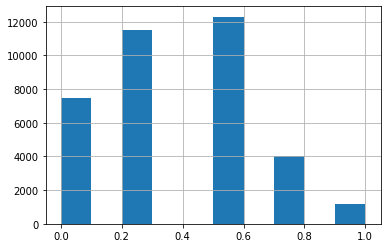

In [15]:
# histogram of the score
df.score.hist()

In [16]:
df[df.score == 1] # minor rewording of the same concept

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


## Training Setup

In [17]:
from torch.utils.data import DataLoader
import warnings, transformers, logging, torch
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [18]:
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [19]:
# use a model that train under 2 min
model_nm = 'microsoft/deberta-v3-small' # roberta, bart

In [20]:
%pip install sentencepiece -q # In order to use the autotokenizer sentencepiece should be installed

In [21]:
# when using pretrained models, tokenizer has to match with the pretrained model
# use AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
# Let's combine the context, anchor, target together into a single str. 
# Model needs to know where each section starts, we use a special separator token to inform the model

In [23]:
sep = tokz.sep_token; sep

'[SEP]'

In [24]:
df['inputs'] = df.context + sep + df.anchor + sep + df.target

In [25]:
# convert from pandas df into hf datasets for performance reasons
# rename the column 'score' into 'label'
ds = Dataset.from_pandas(df).rename_column('score', 'label')
eval_ds = Dataset.from_pandas(eval_df)

In [26]:
def tok_func(x): return tokz(x['inputs'])

In [27]:
ds[0]

{'anchor': 'abatement',
 'context': 'A47',
 'id': '37d61fd2272659b1',
 'inputs': 'A47[SEP]abatement[SEP]abatement of pollution',
 'label': 0.5,
 'section': 'A',
 'target': 'abatement of pollution'}

In [28]:
tok_func(ds[0])

{'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [29]:
tokz.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [30]:
inps = 'anchor', 'target', 'context'
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs', 'id', 'section'))

  0%|          | 0/37 [00:00<?, ?ba/s]

In [31]:
tok_ds[0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'label': 0.5,
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

## Creating a Validation Set

https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/315220 shows the private test anchors do not overlap with the training set.

In [32]:
L(set(eval_df.anchor))

(#34) ['oil tankers','clocked storage','polls','diesel fuel tank','overflow device','speed control means','angular contact bearing','generate in layer','lower trunnion','chemical activity'...]

In [33]:
L(set(df.anchor).intersection(eval_df.anchor))

(#34) ['oil tankers','clocked storage','polls','diesel fuel tank','overflow device','speed control means','angular contact bearing','generate in layer','lower trunnion','chemical activity'...]

We can confirm that test set anchors and training set anchor do not overlap. In order to avoid overfit, we need to create folds grouped by anchors.

Either use abhishek code to create folds properly https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

In [34]:
anchors = df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

In [35]:
# pick 25% of the anchors for validation set
val_prop = 0.25
val_sz = int(len(anchors) * val_prop)
val_anchors = anchors[:val_sz]

In [36]:
# Get a list of rows matching val_anchors & get the indices
is_val = np.isin(df.anchor, val_anchors);is_val

array([False, False, False, ..., False, False, False])

In [37]:
idxs = np.arange(len(df))
val_idxs = idxs[is_val]
trn_idxs = idxs[~is_val]
len(trn_idxs), len(val_idxs)

(27357, 9116)

In [38]:
dds = DatasetDict({'train': tok_ds.select(trn_idxs), 'test': tok_ds.select(val_idxs)})

In [39]:
df.iloc[trn_idxs].score.mean(),df.iloc[val_idxs].score.mean()

(0.3623021530138539, 0.3613426941641071)

## Initial Model

In [40]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [41]:
lr, bs = 8e-5, 128
wd, epochs = 0.01, 4

In [42]:
def get_trainer(dds):
  args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', 
                        fp16=True, evaluation_strategy='epoch', per_device_train_batch_size=bs, 
                        per_device_eval_batch_size=bs*2, num_train_epochs=epochs, weight_decay=wd, 
                        report_to='none')
  model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
  return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz,
                 compute_metrics=corr)

In [43]:
# Q: why bs*2 is set for validation set compared to training?
# num_labels is set to 1 is because we are trying to predict a continuous value ie similarity score
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', 
                        fp16=True, evaluation_strategy='epoch', per_device_train_batch_size=bs, 
                        per_device_eval_batch_size=bs*2, num_train_epochs=epochs, weight_decay=wd, 
                        report_to='none')
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [44]:
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz,
                 compute_metrics=corr)

Using amp half precision backend


In [45]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27357
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025479,0.797386
2,No log,0.025856,0.811856
3,0.033800,0.023601,0.818818
4,0.033800,0.024211,0.818897


***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=856, training_loss=0.025115867641484626, metrics={'train_runtime': 186.0847, 'train_samples_per_second': 588.055, 'train_steps_per_second': 4.6, 'total_flos': 469191313065600.0, 'train_loss': 0.025115867641484626, 'epoch': 4.0})

## Improving the model

Tip: Before starting to improve on the model, ensure the model gives stable results (run it 3 times from scratch and identify the range of scores).Later on once we got the basics right, we can use cross validation, more epochs for training.

Iteration speed is critical to try different data processing & training params.

In [56]:
def get_dds(df):
  ds = Dataset.from_pandas(df).rename_column('score', 'label')
  inps = 'anchor', 'target', 'context'
  tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs', 'id', 'section'))
  
  return DatasetDict({'train': tok_ds.select(trn_idxs), 'test': tok_ds.select(val_idxs)})

In [57]:
  def get_model():
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', 
                        fp16=True, evaluation_strategy='epoch', per_device_train_batch_size=bs, 
                        per_device_eval_batch_size=bs*2, num_train_epochs=epochs, weight_decay=wd, 
                        report_to='none')
    return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

  def get_trainer(dds, model=None):
    if model is None: model=get_model()
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz,
                   compute_metrics=corr)

### Custom Separator Token

Instead of using the default separator token, we will use our own custom separator token.




In [58]:
sep = " [s] "
df['inputs'] = df.context + sep + df.anchor + sep + df.target

dds = get_dds(df)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [59]:
get_trainer(dds). train()

PyTorch: setting up devices
loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027533,0.798065
2,No log,0.026452,0.811252
3,0.037000,0.023933,0.817527
4,0.037000,0.024625,0.817902


***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=856, training_loss=0.027026750774027032, metrics={'train_runtime': 204.3475, 'train_samples_per_second': 535.5, 'train_steps_per_second': 4.189, 'total_flos': 582440534448480.0, 'train_loss': 0.027026750774027032, 'epoch': 4.0})

### Lowercasing the inputs

In [60]:
df['inputs'] = df.inputs.str.lower()
dds = get_dds(df)
get_trainer(dds).train()

  0%|          | 0/37 [00:00<?, ?ba/s]

PyTorch: setting up devices
loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025379,0.798126
2,No log,0.024917,0.815364
3,0.032200,0.023173,0.820424
4,0.032200,0.024181,0.820457


***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=856, training_loss=0.024172265952992662, metrics={'train_runtime': 204.4835, 'train_samples_per_second': 535.143, 'train_steps_per_second': 4.186, 'total_flos': 582440534448480.0, 'train_loss': 0.024172265952992662, 'epoch': 4.0})

### Patent Section as Special Tokens

This allows the model to recognize the different sections to be handled differently. Eg. [A] for section A


In [62]:
df['sectok'] = '[' + df.section + ']'
sectoks = list(df.sectok.unique());sectoks

['[A]', '[C]', '[F]', '[H]', '[B]', '[D]', '[E]', '[G]']

In [63]:
tokz.add_special_tokens({'additional_special_tokens': sectoks})

Assigning ['[A]', '[C]', '[F]', '[H]', '[B]', '[D]', '[E]', '[G]'] to the additional_special_tokens key of the tokenizer
Adding [A] to the vocabulary
Adding [C] to the vocabulary
Adding [F] to the vocabulary
Adding [H] to the vocabulary
Adding [B] to the vocabulary
Adding [D] to the vocabulary
Adding [E] to the vocabulary
Adding [G] to the vocabulary


8

Since we have added more tokens, we need to resize the embedding matrix in the model.

In [64]:
model = get_model()
model.resize_token_embeddings(len(tokz))

PyTorch: setting up devices
loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  

Embedding(128009, 768)

In [65]:
get_trainer(dds, model=model).train()

Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27357
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025379,0.798126
2,No log,0.024917,0.815364
3,0.032200,0.023173,0.820424
4,0.032200,0.024181,0.820457


***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9116
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=856, training_loss=0.024172265952992662, metrics={'train_runtime': 203.6936, 'train_samples_per_second': 537.219, 'train_steps_per_second': 4.202, 'total_flos': 582440534448480.0, 'train_loss': 0.024172265952992662, 'epoch': 4.0})

## Cross Validation

Let's use cross-validation to see the impact of minor changes. By using [StratifiedGroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold), we can get a slightly better balanced datasets.

In [66]:
n_folds = 4
from sklearn.model_selection import StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=n_folds)

Let's split the df into n_folds groups with non_overlapping anchors and matched scores after randomly shuffling the rows.

In [67]:
df = df.sample(frac=1, random_state=42) # random shuffling

In [69]:
scores = (df.score*100).astype(int)

In [70]:
folds = list(cv.split(idxs, y=scores, groups=df.anchor)); folds

[(array([    0,     1,     2, ..., 36469, 36471, 36472]),
  array([    8,    13,    14, ..., 36453, 36464, 36470])),
 (array([    0,     1,     5, ..., 36470, 36471, 36472]),
  array([    2,     3,     4, ..., 36459, 36461, 36462])),
 (array([    1,     2,     3, ..., 36467, 36470, 36472]),
  array([    0,     7,    11, ..., 36468, 36469, 36471])),
 (array([    0,     2,     3, ..., 36469, 36470, 36471]),
  array([    1,     5,     9, ..., 36465, 36467, 36472]))]

In [76]:
for i, _ in enumerate(folds):
  print(len(L(folds)[i][0]), len(L(folds)[i][1]))

27346 9127
27368 9105
27351 9122
27354 9119


In [77]:
def get_fold(folds, fold_num):
  train, val = folds[fold_num]
  return DatasetDict({"train": tok_ds.select(train), "test": tok_ds.select(val)})

In [78]:
dds = get_fold(folds, 0)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27346
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9127
    })
})

In [79]:
trainer.state.log_history

[{'epoch': 1.0,
  'eval_loss': 0.025478700175881386,
  'eval_pearson': 0.7973863392306817,
  'eval_runtime': 2.8593,
  'eval_samples_per_second': 3188.216,
  'eval_steps_per_second': 12.591,
  'step': 214},
 {'epoch': 2.0,
  'eval_loss': 0.02585632912814617,
  'eval_pearson': 0.8118561934499451,
  'eval_runtime': 2.9696,
  'eval_samples_per_second': 3069.787,
  'eval_steps_per_second': 12.123,
  'step': 428},
 {'epoch': 2.34,
  'learning_rate': 3.544034360437838e-05,
  'loss': 0.0338,
  'step': 500},
 {'epoch': 3.0,
  'eval_loss': 0.023600663989782333,
  'eval_pearson': 0.818817922771115,
  'eval_runtime': 3.027,
  'eval_samples_per_second': 3011.516,
  'eval_steps_per_second': 11.893,
  'step': 642},
 {'epoch': 4.0,
  'eval_loss': 0.024211233481764793,
  'eval_pearson': 0.8188965608126276,
  'eval_runtime': 2.9877,
  'eval_samples_per_second': 3051.218,
  'eval_steps_per_second': 12.05,
  'step': 856},
 {'epoch': 4.0,
  'step': 856,
  'total_flos': 469191313065600.0,
  'train_loss': 0

In [80]:
metrics = [o['eval_pearson'] for o in trainer.state.log_history if 'eval_pearson' in o]
metrics[-1]

0.8188965608126276

We can now pass this into get_trainer as we did before. If we have, say, 4 folds, then doing that for each fold will give us 4 models, and 4 sets of predictions and metrics. You could ensemble the 4 models to get a stronger model, and can also average the 4 metrics to get a more accurate assessment of your model.

In [81]:
all_metrics = []

for i, _ in enumerate(folds):
  trainer = get_trainer(get_fold(folds, i), model=model)
  trainer.train()
  metrics = [o['eval_pearson'] for o in trainer.state.log_history if 'eval_pearson' in o]
  all_metrics.append(metrics[-1])

Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27346
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.015355,0.889927
2,No log,0.013862,0.894369
3,0.014900,0.014418,0.897626
4,0.014900,0.014143,0.898233


***** Running Evaluation *****
  Num examples = 9127
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9127
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 9127
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9127
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)


Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementatio

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.010297,0.936324
2,No log,0.007896,0.939358
3,0.010500,0.008110,0.941794
4,0.010500,0.008160,0.942007


***** Running Evaluation *****
  Num examples = 9105
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9105
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 9105
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9105
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)


Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementatio

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.005499,0.960845
2,No log,0.005387,0.960178
3,0.007700,0.005525,0.961639
4,0.007700,0.005574,0.961658


***** Running Evaluation *****
  Num examples = 9122
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9122
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 9122
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9122
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)


Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementatio

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.004927,0.969608
2,No log,0.004385,0.970904
3,0.006200,0.004069,0.972956
4,0.006200,0.004014,0.973434


***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




In [82]:
all_metrics

[0.8982331512430004,
 0.9420067581041071,
 0.9616583091932731,
 0.9734337554029711]